
A long time ago in 1902, Johannes von Kries proposed (not as equations) the following chromatic adaptation model:

<h5><center>"This can be conceived in the sense that the individual components present
in the organ of vision are completely independent of one another and each
is fatigued or adapted exclusively according to its own function "[trans.
MacAdam 1970: 118].</center></h5>

In the  Von Kries model we simply will multiply each channel of the image with a gain after normalize its individual intensity. However, note that there are some implications in this approach. The first one is that the channels are considered independent signals (as Von Kries proposed), thats why we have independent gains. Second, this gain is added not in the RGB space but in the tristimulus space LMS. In this tutorial we follow the theory of Fairchild[2], for further details please refer to his marvelous book. 

If LMS corresponds to the tristimulus values of our image, the von Kries model mathemathically can be expressed as:

\begin{equation*}
L_2 =\frac{L_1}{L_{max}}L_{max2};M_2 =\frac{M_1}{M_{max}}M_{max2};S_2 =\frac{S_1}{S_{max}}S_{max2}
\end{equation*}

Where L_1 corresponds to original images L values, L_Max corresponds to maximum value or reference white in the original image in the L channel, L_Max2 is the gain value (or new light condition),and L_2 is the corrected L channel. Same for the other two channels. For those vectorized guys who can not affor any for-loop:

\begin{equation*}
 \begin{bmatrix}
L_2 \\
M_2 \\
S_2 
\end{bmatrix} =\begin{bmatrix}
L_{max2} & 0 & 0 \\
0 & M_{max2} & 0 \\
0 & 0 & S_{max2}
\end{bmatrix}  \begin{bmatrix}
\frac{1}{L_{max}} & 0 & 0 \\
0 & \frac{1}{M_{max}} & 0 \\
0 & 0 & \frac{1}{S_{max}} 
\end{bmatrix} \begin{bmatrix}
L_1 \\
M_1 \\
S_2 
\end{bmatrix}
\end{equation*}

Furthermore, the process is summarzed as follows:

1. Transform your input RGB image to LMS tristimulus space
2. Divide each channel by its maximum of reference maximum
3. Multiply each channel with each gain
4. Transform the result again to RGB space

Ok, lets code that!

First we need to import as usual the python libraries that we are goint to use
## Libraries

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from numpy.linalg import inv
from __future__ import division

/usr/lib/python3/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/lib/python3/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Here we put the parameters of matrixes that we will use, two variables are important here:

1. The M matrix, which will help us to transfrom from XYZ space to LMS tristimulus space
2. The XYZ2BGR matrix, which will help us to transfrom from XYZ space to RGB space

Of course the inverse matrixes of these two variables are important as well. You can find these conversion matrixes an more in [1]

## Parameters

In [30]:
#Hunt-Pointer-Estevez transformation matrix from XYZ to LMS
M = np.asarray([[.40024,0.7076,-.08081], [-.2263,1.16532,0.0457],[0,0,.91822]])
int_M = inv(M)
XYZ2BGR = np.asarray([[3.240479,-1.53715,-0.498535], [-0.969256,1.875991,0.041556],[0.055648,-0.204043,1.057311]])
BGR2XYZ = inv(XYZ2BGR)


The following variables represent the new light conditions or if you wish, the gain parameter that will modify our image

In [34]:
# New maximum channel values, put values between 0 and 1
L2 = 0.5
M2 = 0.5
S2 = 0.5

Ok lets serve the main dish. Here we load the image, create some numpy matrixes that will help us and finalla a transformation of color space is done. Note that we can not transform directly from RGB to LMS space, instead we use an intermdiate transformation to CIE XYZ space. This part of the code corresponds to the point one of our summary
## Main

In [35]:
# Load source image and create empty images
img = cv2.imread('./img/cablecar.bmp')# pepper.bmp,baboon.bmp,sailboat.bmp,cablecar.bmp,flowers.bmp,barbara.bmp
width = img.shape[0]
height = img.shape[1]
img_LMS = np.zeros(img.shape)
img_XYZ = np.zeros(img.shape)
img_XYZ_corrected = np.zeros(img.shape)
img_corrected = np.zeros(img.shape)

# First transform image to CIE XYZ
for x in range(width):
    for y in range(height):
        img_XYZ[x,y,:] = np.matmul(BGR2XYZ,img[x,y,:]/255)
        
# Transform CIE XYZ to relative cone responses (LMS) using matrix M
for x in range(width):
    for y in range(height):
        img_LMS[x,y,:] = np.matmul(M,img_XYZ[x,y,:])
    


Now we will find the maximum value in each channel (remember we are now in the LMS space) and normalize each channel using this value. Note that instead of this you can just set up you maximum (if you already know it). This corresponds to the step 2 of our summary

In [36]:
# Find maximum stimulus per channel and normalize the image using it
L_max = img_LMS[:,:,0].max()
M_max = img_LMS[:,:,1].max()
S_max = img_LMS[:,:,2].max()

img_LMS[:,:,0] = img_LMS[:,:,0]/L_max
img_LMS[:,:,1] = img_LMS[:,:,1]/M_max
img_LMS[:,:,2] = img_LMS[:,:,2]/S_max

Now is time to scale our image using the new light conditions or as previusly said, multiply each channel for our gains. his corresponds to the step 3 of our summary 

In [37]:
# Scale to new maximum values
img_LMS[:,:,0] = img_LMS[:,:,0]*L2
img_LMS[:,:,1] = img_LMS[:,:,1]*M2
img_LMS[:,:,2] = img_LMS[:,:,2]*S2        


Finally, lets return our image to the original RGB space.This corresponds to the step 4 of our summary

In [38]:
# Convert image to CIE XYZ
for x in range(width):
    for y in range(height):
        img_XYZ_corrected[x,y,:] = np.matmul(int_M,img_LMS[x,y,:])
    
# Convert from CIE XYZ to BGR
#img_corrected = cv2.cvtColor(img_XYZ_corrected, cv2.COLOR_XYZ2BGR)

for x in range(width):
    for y in range(height):
        img_corrected[x,y,:] = np.matmul(XYZ2BGR,img_XYZ_corrected[x,y,:])

## Plot results

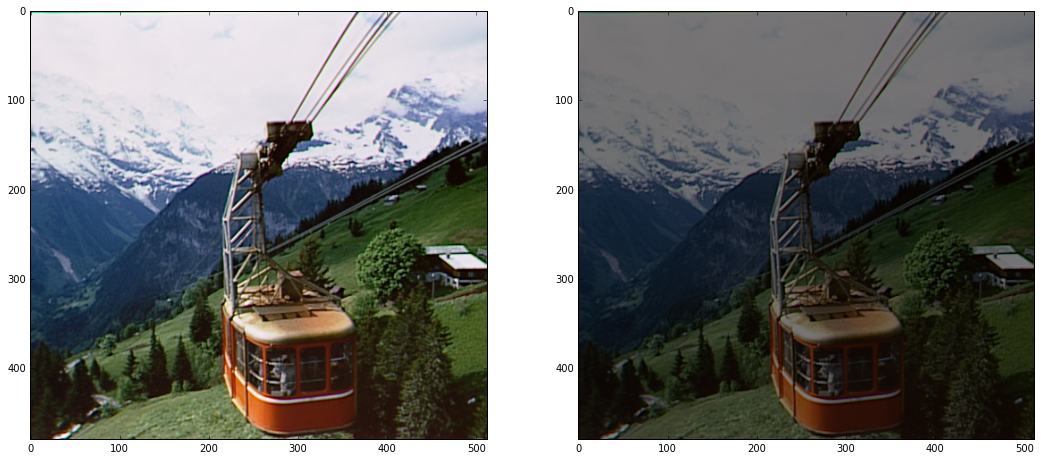

In [39]:
# Show results
results_RGB = np.zeros(img_XYZ.shape)
results_RGB[:,:,0] = img_corrected[:,:,2]
results_RGB[:,:,1] = img_corrected[:,:,1]
results_RGB[:,:,2] = img_corrected[:,:,0]
f, axarr = plt.subplots(1,2,figsize=(18, 16))
axarr[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axarr[1].imshow(((results_RGB)),vmin=results_RGB.min(),vmax=results_RGB.max())


In our first results we see a darker image, which is actually correct! Remember that out gain values were 0.5 for each channel, that is, we are telling our algorithm that the new conditions are darker.

Now, lets change the gain values to one, that is L2 = M2 = S2 = 1 and execute our algorithm again

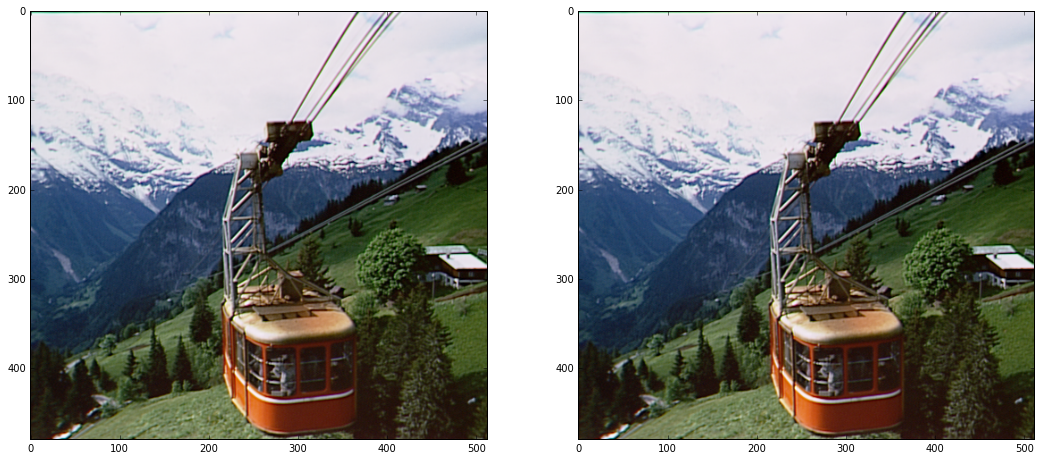

In [42]:
# New maximum channel values, put values between 0 and 1
L2 = 1
M2 = 1
S2 = 1

# Transform CIE XYZ to relative cone responses (LMS) using matrix M
for x in range(width):
    for y in range(height):
        img_LMS[x,y,:] = np.matmul(M,img_XYZ[x,y,:])

# Find maximum stimulus per channel and normalize the image using it
L_max = img_LMS[:,:,0].max()
M_max = img_LMS[:,:,1].max()
S_max = img_LMS[:,:,2].max()

# Scale to new maximum values
img_LMS[:,:,0] = img_LMS[:,:,0]*L2
img_LMS[:,:,1] = img_LMS[:,:,1]*M2
img_LMS[:,:,2] = img_LMS[:,:,2]*S2        

# Convert image to CIE XYZ
for x in range(width):
    for y in range(height):
        img_XYZ_corrected[x,y,:] = np.matmul(int_M,img_LMS[x,y,:])
    
# Convert from CIE XYZ to BGR
#img_corrected = cv2.cvtColor(img_XYZ_corrected, cv2.COLOR_XYZ2BGR)

for x in range(width):
    for y in range(height):
        img_corrected[x,y,:] = np.matmul(XYZ2BGR,img_XYZ_corrected[x,y,:])

        
# Show results
results_RGB = np.zeros(img_XYZ.shape)
results_RGB[:,:,0] = img_corrected[:,:,2]
results_RGB[:,:,1] = img_corrected[:,:,1]
results_RGB[:,:,2] = img_corrected[:,:,0]
f, axarr = plt.subplots(1,2,figsize=(18, 16))
axarr[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axarr[1].imshow(((results_RGB)),vmin=results_RGB.min(),vmax=results_RGB.max())
        
        

In this case we are not doing more that normalize each channel by its maximum, due to our gain is 1 (that means multiply by 1). However if you detail the image you will see that the results is actually brighter, this normalization process is a popular white balance algorithm called White patch.

Till this moment we have made the gain values equal for all the channels, but we can change that (remember they are independent in von Kries theory). If we tell the algorithm that the red channel has more gain, as expected we will get a reddish image.

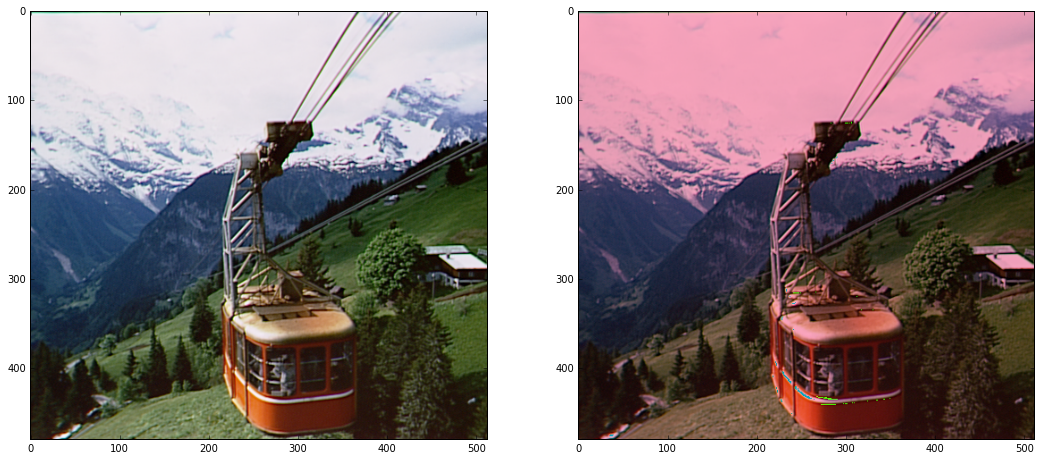

In [44]:
# New maximum channel values, put values between 0 and 1
L2 = 0.75
M2 = 0.75
S2 = 1

# Transform CIE XYZ to relative cone responses (LMS) using matrix M
for x in range(width):
    for y in range(height):
        img_LMS[x,y,:] = np.matmul(M,img_XYZ[x,y,:])

# Find maximum stimulus per channel and normalize the image using it
L_max = img_LMS[:,:,0].max()
M_max = img_LMS[:,:,1].max()
S_max = img_LMS[:,:,2].max()

# Scale to new maximum values
img_LMS[:,:,0] = img_LMS[:,:,0]*L2
img_LMS[:,:,1] = img_LMS[:,:,1]*M2
img_LMS[:,:,2] = img_LMS[:,:,2]*S2        

# Convert image to CIE XYZ
for x in range(width):
    for y in range(height):
        img_XYZ_corrected[x,y,:] = np.matmul(int_M,img_LMS[x,y,:])
    
# Convert from CIE XYZ to BGR
#img_corrected = cv2.cvtColor(img_XYZ_corrected, cv2.COLOR_XYZ2BGR)

for x in range(width):
    for y in range(height):
        img_corrected[x,y,:] = np.matmul(XYZ2BGR,img_XYZ_corrected[x,y,:])

        
# Show results
results_RGB = np.zeros(img_XYZ.shape)
results_RGB[:,:,0] = img_corrected[:,:,2]
results_RGB[:,:,1] = img_corrected[:,:,1]
results_RGB[:,:,2] = img_corrected[:,:,0]
f, axarr = plt.subplots(1,2,figsize=(18, 16))
axarr[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axarr[1].imshow(((results_RGB)),vmin=results_RGB.min(),vmax=results_RGB.max())

Imagine that your source image seems reddish or yellow, you can apply the von Kries algorithm to change the gain of each channel and correct the image!

Lets get nasty now, what happens if we put out gain out of the range (that is >1)? Well, in that case we will have numbers out of the rage of representation (this mainly happens in the transformations in color space) and we will get really crazt results!

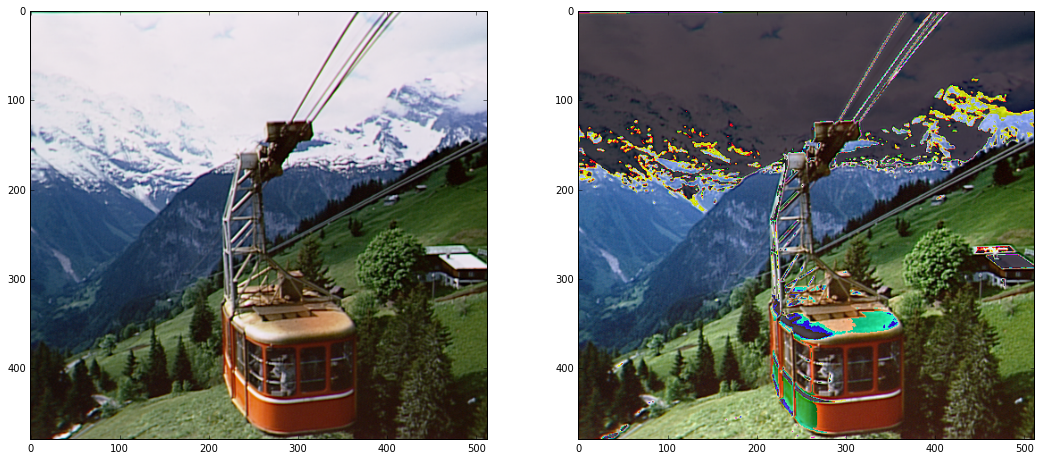

In [46]:
# New maximum channel values, put values between 0 and 1
L2 = 1.4
M2 = 1.4
S2 = 1.4

# Transform CIE XYZ to relative cone responses (LMS) using matrix M
for x in range(width):
    for y in range(height):
        img_LMS[x,y,:] = np.matmul(M,img_XYZ[x,y,:])

# Find maximum stimulus per channel and normalize the image using it
L_max = img_LMS[:,:,0].max()
M_max = img_LMS[:,:,1].max()
S_max = img_LMS[:,:,2].max()

# Scale to new maximum values
img_LMS[:,:,0] = img_LMS[:,:,0]*L2
img_LMS[:,:,1] = img_LMS[:,:,1]*M2
img_LMS[:,:,2] = img_LMS[:,:,2]*S2        

# Convert image to CIE XYZ
for x in range(width):
    for y in range(height):
        img_XYZ_corrected[x,y,:] = np.matmul(int_M,img_LMS[x,y,:])
    
# Convert from CIE XYZ to BGR
#img_corrected = cv2.cvtColor(img_XYZ_corrected, cv2.COLOR_XYZ2BGR)

for x in range(width):
    for y in range(height):
        img_corrected[x,y,:] = np.matmul(XYZ2BGR,img_XYZ_corrected[x,y,:])

        
# Show results
results_RGB = np.zeros(img_XYZ.shape)
results_RGB[:,:,0] = img_corrected[:,:,2]
results_RGB[:,:,1] = img_corrected[:,:,1]
results_RGB[:,:,2] = img_corrected[:,:,0]
f, axarr = plt.subplots(1,2,figsize=(18, 16))
axarr[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axarr[1].imshow(((results_RGB)),vmin=results_RGB.min(),vmax=results_RGB.max())

Thats all folks! I hope you enjoy this tutorial

## References
 [1] http://www.brucelindbloom.com/
 
 [2] Fairchild, M.D., 2013. Color appearance models. John Wiley & Sons.